In [1]:
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 12})

from matplotlib import font_manager
font_manager.fontManager.addfont('../../misc/lucida-sans-unicode.ttf')

import seaborn as sns
tregs.mpl_pboc.plotting_style()

{'green': '#7AA974',
 'light_green': '#BFD598',
 'pale_green': '#DCECCB',
 'yellow': '#EAC264',
 'light_yellow': '#F3DAA9',
 'pale_yellow': '#FFEDCE',
 'blue': '#738FC1',
 'light_blue': '#A9BFE3',
 'pale_blue': '#C9D7EE',
 'red': '#D56C55',
 'light_red': '#E8B19D',
 'pale_red': '#F1D4C9',
 'purple': '#AB85AC',
 'light_purple': '#D4C2D9',
 'dark_green': '#7E9D90',
 'dark_brown': '#905426'}

Here we use CRP binding at the lacZYA promoter as a case study for simple activation.

## 0. Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# CRP binding site
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'

In [5]:
#crp_site = 'ATTAATGTGAGTTAGCTCACTCATT'
#crp_emat_raw = pd.read_csv('../../data/energy_matrices/2011_lacZ_MG1655_M9glucose_na_mut1_4bins_CRP_emat_mean.csv')
#crp_emat_raw = crp_emat_raw[['A', 'C', 'G', 'T']]
#crp_emat = crp_emat_raw.to_numpy().T
#crp_emat = tregs.simulate.fix_wt(crp_emat, crp_site)

In [6]:
# energy matrix obtained from Fig 3. of Kinney et al., 2010 (https://www.pnas.org/doi/full/10.1073/pnas.1004290107)
# elements expressed in kcal/mol (1 kcal/mol = 1.62kbT)

crp_emat_raw = pd.read_table('../../data/energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy().T * 1.62

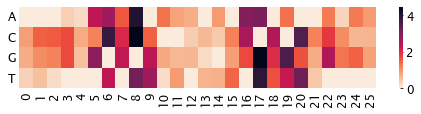

In [7]:
fig, ax = plt.subplots(figsize=(8, 1.5))

cmap = sns.color_palette("rocket_r", as_cmap=True)
sns.heatmap(crp_emat, cmap=cmap, ax=ax)
ax.set_yticklabels(['A', 'C', 'G', 'T'], rotation=360)
plt.show()

In [8]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

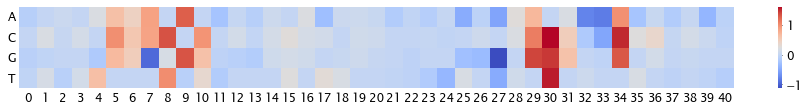

In [9]:
fig, ax = plt.subplots(figsize=(16, 1.5))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(rnap_emat.T, cmap=cmap, ax=ax)
ax.set_yticklabels(['A', 'C', 'G', 'T'], rotation=360)
plt.show()

## Building synthetic dataset

In [10]:
def simact_pbound(p_seq, a_seq, p_emat, a_emat, n_p, n_a, n_NS,
                  ep_wt=0, ea_wt=0, e_ap=0):

    p = (n_p / n_NS) * tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    a = (n_a / n_NS) * tregs.simulate.get_weight(a_seq, a_emat, e_wt=ea_wt)
    w = np.exp(-e_ap)

    pbound = (p + a * p * w) / (1 + a + p + a * p * w)

    return pbound


def simact_helper(mutants, rnap_start, rnap_end, act_start, act_end,
                  rnap_emat, act_emat, n_p, n_a, n_NS,
                  ep_wt=0, ea_wt=0, e_ap=0):

    l_tr = []
    for mut in mutants:
        rv = {}
        rv['seq'] = mut
        rnap_mut = mut[rnap_start:rnap_end].upper()
        act_mut = mut[act_start:act_end].upper()
        rv['pbound'] = simact_pbound(rnap_mut, act_mut, rnap_emat, act_emat,
                                     n_p, n_a, n_NS,
                                     ep_wt=ep_wt, ea_wt=ea_wt, e_ap=e_ap)
        l_tr.append(rv)
    df = pd.DataFrame.from_records(l_tr)

    return df


def simact(wtseq, rnap_wtseq, act_wtseq,
           rnap_emat, act_emat, n_p, n_a, n_NS,
           ep_wt=0, ea_wt=0, e_ap=0,
           num_mutants=10000, scaling_factor=100):
    
    mutants = np.unique(tregs.wgregseq.mutations_rand(
                                    wtseq,
                                    rate=0.1,
                                    num_mutants=num_mutants,
                                    number_fixed=True))

    rnap_start, rnap_end = tregs.seq_utils.find_binding_site(wtseq, rnap_wtseq)
    act_start, act_end = tregs.seq_utils.find_binding_site(wtseq, act_wtseq)

    df = simact_helper(mutants, rnap_start, rnap_end, act_start, act_end,
                       rnap_emat, act_emat, n_p, n_a, n_NS,
                       ep_wt, ea_wt, e_ap)
    
    dna_cnt = tregs.simulate.get_dna_cnt(len(df))
    df['ct_0'] = dna_cnt
    df = df[df.ct_0 != 0.0]

    df['ct_1'] = 1 + df['ct_0'] * df['pbound'] * scaling_factor
    df['ct_1'] = df['ct_1'].astype(int)
    
    df['ct_0'] = df['ct_0'].astype(float)
    df['ct_1'] = df['ct_1'].astype(float)
    df['norm_ct_1'] = df['ct_1'] / df['ct_0']

    return df

In [11]:
def plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound):
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=10**(-6))
    exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                        smoothed=True, windowsize=3)
    
    fig, ax = plt.subplots(figsize=(12,2.5))

    ax.axvspan(-38, -30, alpha=0.7, color='#A9BFE3')
    ax.axvspan(-15, -5, alpha=0.7, color='#A9BFE3')
    ax.axvspan(-70, -52, alpha=0.7, color='#DCECCB')

    ax.set_ylim(top=max(footprint)*1.15)
    ax.add_patch(mpl.patches.Rectangle((-38, max(footprint)*1.15),
                                            8,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-38 + 0.5 * 8, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')

    ax.add_patch(mpl.patches.Rectangle((-15, max(footprint)*1.15),
                                            10,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-15 + 0.5 * 10, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')

    ax.add_patch(mpl.patches.Rectangle((-70, max(footprint)*1.15),
                                            18,
                                            max(footprint) * 0.2,
                                            facecolor='#7AA974',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-70 + 0.5 * 18, max(footprint) * 1.2, 'CRP', fontsize = 10, color = 'k',
            ha='center', va='baseline')


    windowsize=3
    cut = int((windowsize - 1) / 2)
    x = np.arange(-115 + cut, 45 - cut)
    shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
    ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
    ax.set_ylabel('Information (bits)', fontsize=12)

    custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                    Line2D([0], [0], color='#738FC1', lw=4)]
    plt.legend(custom_lines,
            ['Mutation\nincreases\nexpression', 'Mutation\ndecreases\nexpression'],
            bbox_to_anchor=(1.2, 0.95), frameon=False)

    plt.tight_layout()
    #plt.savefig('../../figs/simact_footprint.png', dpi=300, bbox_inches='tight')
    plt.show()

In [12]:
n_NS = len(genome)
n_p = 4600
n_a = 50
ep_wt = -13 #8.3 * 1.62
ea_wt = -11 #6.9 * 1.62
e_ap = -5 #3.3 * 1.62

df = simact(promoter, rnap_site, crp_site,
           rnap_emat, crp_emat, n_p, n_a, n_NS,
           ep_wt=ep_wt, ea_wt=ea_wt, e_ap=e_ap)

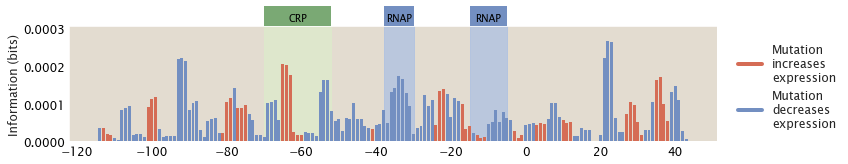

In [13]:
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = np.mean(mu_data) * 1.1
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound)

In [14]:
## scaling down all the energy terms

n_NS = len(genome)
n_p = 4600
n_a = 50
ep_wt = -8
ea_wt = -7
e_ap = -3

df = simact(promoter, rnap_site, crp_site,
           rnap_emat, crp_emat, n_p, n_a, n_NS,
           ep_wt=ep_wt, ea_wt=ea_wt, e_ap=e_ap)
n_seqs = len(df)

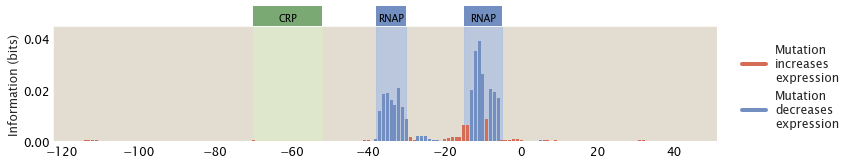

In [15]:
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = np.mean(mu_data) * 1.2
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound)

In [16]:
# only increasing strength of RNAP-activator binding

n_NS = len(genome)
n_p = 4600
n_a = 50
ep_wt = -8
ea_wt = -7
e_ap = -15

df = simact(promoter, rnap_site, crp_site,
           rnap_emat, crp_emat, n_p, n_a, n_NS,
           ep_wt=ep_wt, ea_wt=ea_wt, e_ap=e_ap)

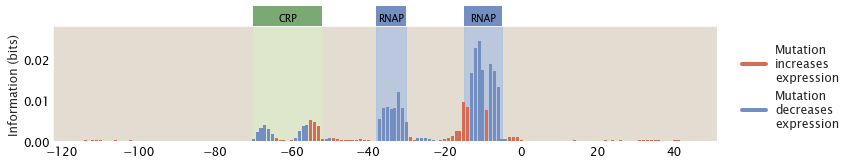

In [17]:
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = np.mean(mu_data) * 1.2
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound)

In [18]:
# only increasing strength of activator-promoter binding

n_NS = len(genome)
n_p = 4600
n_a = 50
ep_wt = -8
ea_wt = -20
e_ap = -3

df = simact(promoter, rnap_site, crp_site,
           rnap_emat, crp_emat, n_p, n_a, n_NS,
           ep_wt=ep_wt, ea_wt=ea_wt, e_ap=e_ap)

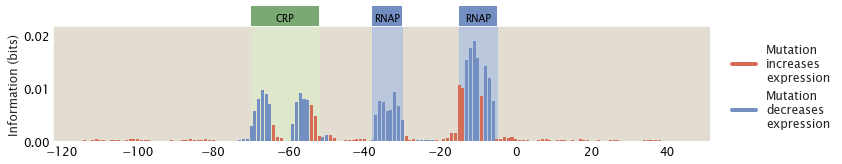

In [19]:
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = np.mean(mu_data) * 1.2
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound)

In [20]:
n_NS = len(genome)
n_p = 4600
n_a = 50
ep_wt = -8
ea_wt = -15
e_ap = -10

df = simact(promoter, rnap_site, crp_site,
           rnap_emat, crp_emat, n_p, n_a, n_NS,
           ep_wt=ep_wt, ea_wt=ea_wt, e_ap=e_ap)

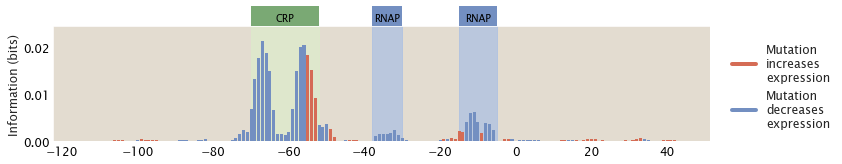

In [21]:
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = np.mean(mu_data) * 1.2
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound)